In [65]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions as et
import MathsUtilities as ms
%matplotlib inline

In [16]:
#function to set up crop variables
def SetCropVariables(Crop,RootRate):
    Paddock.ix[:,'cover'] = 0.0 
    Paddock.ix[:,'rootdepth'] = 0.0
    for date in Paddock.index:
        if date < SowingDate:
            Paddock.ix[date,'cover'] = 0.0
        else:
            if Paddock.ix[date,'Tt'] < CropCoeffs.ix[Crop,'Tt_Sen']:
                Paddock.ix[date,'cover'] = CropCoeffs.ix[Crop,'Ymax']/(1+np.exp(-(Paddock.ix[date,'Tt']-CropCoeffs.ix[Crop,'Xo'])/CropCoeffs.ix[Crop,'b']))
            else:
                if Paddock.ix[date,'Tt'] < CropCoeffs.ix[Crop,'Tt_Mat']:
                    SenRate = CropCoeffs.ix[Crop,'Ymax']/(CropCoeffs.ix[Crop,'Tt_Mat'] - CropCoeffs.ix[Crop,'Tt_Sen'])
                    Paddock.ix[date,'cover'] = CropCoeffs.ix[Crop,'Ymax']-(Paddock.ix[date,'Tt'] - CropCoeffs.ix[Crop,'Tt_Sen'])*SenRate
                else:
                    Paddock.ix[date,'cover'] = 0;
        Paddock.ix[date,'rootdepth']  = min(Paddock.ix[date,'Tt']*RootRate,CropCoeffs.ix[Crop,'MaxRootDepth'])

#Function to infiltrate rainfall
def doPrecipitation(date, Precip):
    Infiltration = Precip
    for depth in Depths:
        key = 'SW' + str(depth)
        yesterday = date - dt.timedelta(1)
        Capacity = SoilWaterParams.ix[depth,'DUL']*SoilWaterParams.ix[depth,'Thickness'] - Paddock.ix[yesterday,key]
        Absorption = min(Capacity,Infiltration)
        Paddock.ix[date,key] = Paddock.ix[yesterday,key] + Absorption
        Infiltration -= Absorption
    Paddock.ix[date,'Drainage'] = Infiltration

#Function to remove evaporation
def doEvaporation(date,ES):
    yesterday = date - dt.timedelta(1)
    for depth in Depths:
        key = 'SW' + str(depth)    
        EvapCap = (Paddock.ix[yesterday,key] - SoilWaterParams.ix[depth,'LL']*SoilWaterParams.ix[depth,'Thickness'] ) * SoilWaterParams.ix[depth,'erk']
        EvapAct = min(ES,EvapCap)
        Paddock.ix[date,key] -= EvapAct

#Function to remove transpiration
def doTranspiration(date,ET):
    yesterday = date - dt.timedelta(1)
    TransDem = ET
    for depth in Depths:
        LayThi = SoilWaterParams.ix[depth,'Thickness']
        if depth-LayThi < Paddock.ix[date,'rootdepth']: #Have the roots entered the layer
            if depth < Paddock.ix[date,'rootdepth']: #Have they gone right through the layer
                PropExplored = 1.0
            else: #they are partly through the currently layer
                PropExplored = (Paddock.ix[date,'rootdepth']-(depth-LayThi))/LayThi
            key = 'SW' + str(depth)
            Capacity = (Paddock.ix[date,key] - (SoilWaterParams.ix[depth,'LL'] * LayThi)) * SoilWaterParams.ix[depth,'kl'] * PropExplored
            Uptake = min(TransDem,Capacity)
            Paddock.ix[date,key] -= Uptake
            TransDem -= Uptake

In [17]:
# Set up the soil
Thicknesses = [150,150,300,300,300,300,300]
ObsLabs = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7']
Depths = np.cumsum(Thicknesses)
keys = []
for depth in Depths:
    keys.append('SW'+str(depth))
SoilWaterParams = pd.DataFrame(index=Depths,columns = ['SAT','DUL','LL','kl','InitSWC','InitSW'])
SoilWaterParams.ix[:,'Thickness'] = Thicknesses
SoilWaterParams.ix[:,'DUL'] = [0.36,0.36,0.36,0.36,0.36,0.39,0.39]
SoilWaterParams.ix[:,'LL'] = [0.1,0.15,0.15,0.15,0.15,0.15,0.15]
SoilWaterParams.ix[:,'kl'] = [0.1,0.1,0.1,0.1,0.08,0.08,0.08]
SoilWaterParams.ix[:,'erk'] = [0.05,0.01,0,0,0,0,0]
SoilWaterParams.ix[:,'InitSWC'] = [0.7,0.7,0.8,1,1,1,1]
SoilWaterParams.ix[:,'ObsLab'] = ObsLabs

for depth in SoilWaterParams.index:
    SoilWaterParams.ix[depth,'InitSW'] = (SoilWaterParams.ix[depth,'LL'] + \
                                          (SoilWaterParams.ix[depth,'DUL'] - SoilWaterParams.ix[depth,'LL'])* \
                                          SoilWaterParams.ix[depth,'InitSWC']) * \
                                          SoilWaterParams.ix[depth,'Thickness']

C:\Users\pount\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  if __name__ == '__main__':


In [18]:
# Set up crop coefficient data
CropInfo = ['[Stover].CoverFunction.Expanding.SigCoverFunction.b.Value',
            '[Stover].CoverFunction.Expanding.SigCoverFunction.Xo.Value',
            '[Stover].CoverFunction.Expanding.SigCoverFunction.Ymax.Value',
            'TT_Sen',
            'TT_Mat',
            '[Root].MaximumRootDepth.Value']
CropCoeffNames = ['b','Xo','Ymax','Tt_Sen','Tt_Mat','MaxRootDepth']

#Crop coefficient data
CropImport = pd.read_excel('CropCoeff.xlsx',sheetname='CoreParams',index_col=0)
CropCoeffs = CropImport.ix[:,CropInfo]
CropCoeffs.columns = CropCoeffNames
RootRate = 1

C:\Users\pount\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  if sys.path[0] == '':


In [19]:
# Set up the met file
MetData = pd.read_csv('lincoln.met',sep='\t',skiprows=[1],engine='python',index_col=0,parse_dates=True)

In [20]:
ObsData = pd.read_pickle('SoilVWC.pkl')
Data = ObsData.ix['2014-11-05 08:00:00':'2015-02-11'].groupby(level=['Depth', 'Irrigation', 'Cultivar','Block'],axis=1).mean()
Data =  Data.dropna(axis=1, how = 'all')
Cultivars = ['Dash','Omaka']
Irrigations = ['Low', 'Mid','High']
Blocks = ['1','2','3','4']
for irr in Irrigations:
    for cul in Cultivars:
        for blo in Blocks:
            Data.ix[:,('D1',irr,cul,blo)] = (Data.ix[:,('D1B',irr,cul,blo)] + Data.ix[:,('D1I',irr,cul,blo)])/2

#Calculate the water content of the soil profile by multiplying the volumetric water content by each layers
#depth and summing.  The 0-15 layers are divided by 2 to average the two readings
ProfileWater = Data.ix[:,'D1I'] * 150/2 + \
               Data.ix[:,'D1B'] * 150/2 + \
               Data.ix[:,'D2'] * 150 + \
               Data.ix[:,'D3'] * 300 + \
               Data.ix[:,'D4'] * 300 + \
               Data.ix[:,'D5'] * 300 + \
               Data.ix[:,'D6'] * 300 + \
               Data.ix[:,'D7'] * 300

C:\Users\pount\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  
C:\Users\pount\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  # Remove the CWD from sys.path while we load stuff.


In [62]:
def GraphWatBal(Irrig,Cult,fig,Treat):
    colours = ['r', 'b', 'g']
    
    plt.axes(axs[0][1])
    Ind = ProfileWater.ix[:,(Irrig,Cult)].index
    Med = ProfileWater.ix[:,(Irrig,Cult)].median(axis=1)
    SEM = ProfileWater.ix[:,(Irrig,Cult)].std(axis=1)/np.sqrt(4)
    Upp = Med + SEM
    Low = Med - SEM
    plt.fill_between(Ind,Upp,Low,alpha=0.4,color=colours[Treat-1])
    plt.plot(Ind,Med,'o',mfc=colours[Treat-1],mec=colours[Treat-1],markersize=2)
    plt.plot(Paddock.ix[:,keys].sum(axis=1),color=colours[Treat-1])
    plt.title('Profile Water Content (mm)')

    plt.axes(axs[0][0])
    plt.plot(Paddock.ix[:,'cover'],label='Cover')
    plt.plot(Paddock.ix[:,'rootdepth']/1000,label='Root Depth (m)')
    plt.title('Crop variables')
    row = 1
    col = 0
    for depth in Depths:
        key = 'SW' + str(depth)
        ObsKey = SoilWaterParams.ix[depth,'ObsLab']
        plt.axes(axs[row][col])
        Ind = Data.ix[:,(ObsKey,Irrig,Cult)].index
        Med = Data.ix[:,(ObsKey,Irrig,Cult)].median(axis=1)
        SEM = Data.ix[:,(ObsKey,Irrig,Cult)].std(axis=1)/np.sqrt(4)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,alpha=0.4, color=colours[Treat-1])
        plt.plot(Ind,Med,'o',mfc=colours[Treat-1],mec=colours[Treat-1],markersize=2)
        plt.plot(np.divide(Paddock.ix[:,key],SoilWaterParams.ix[depth,'Thickness']),color=colours[Treat-1])
        plt.title('Layer ' + str(depth) + ' mm depth')
        plt.ylim(0,0.45)
        col +=1
        if col == 2:
            row += 1
            col = 0

C:\Users\pount\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  app.launch_new_instance()
C:\Users\pount\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
C:\Users\pount\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
C:\Users\pount\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: PerformanceWarning: indexing past lexsort

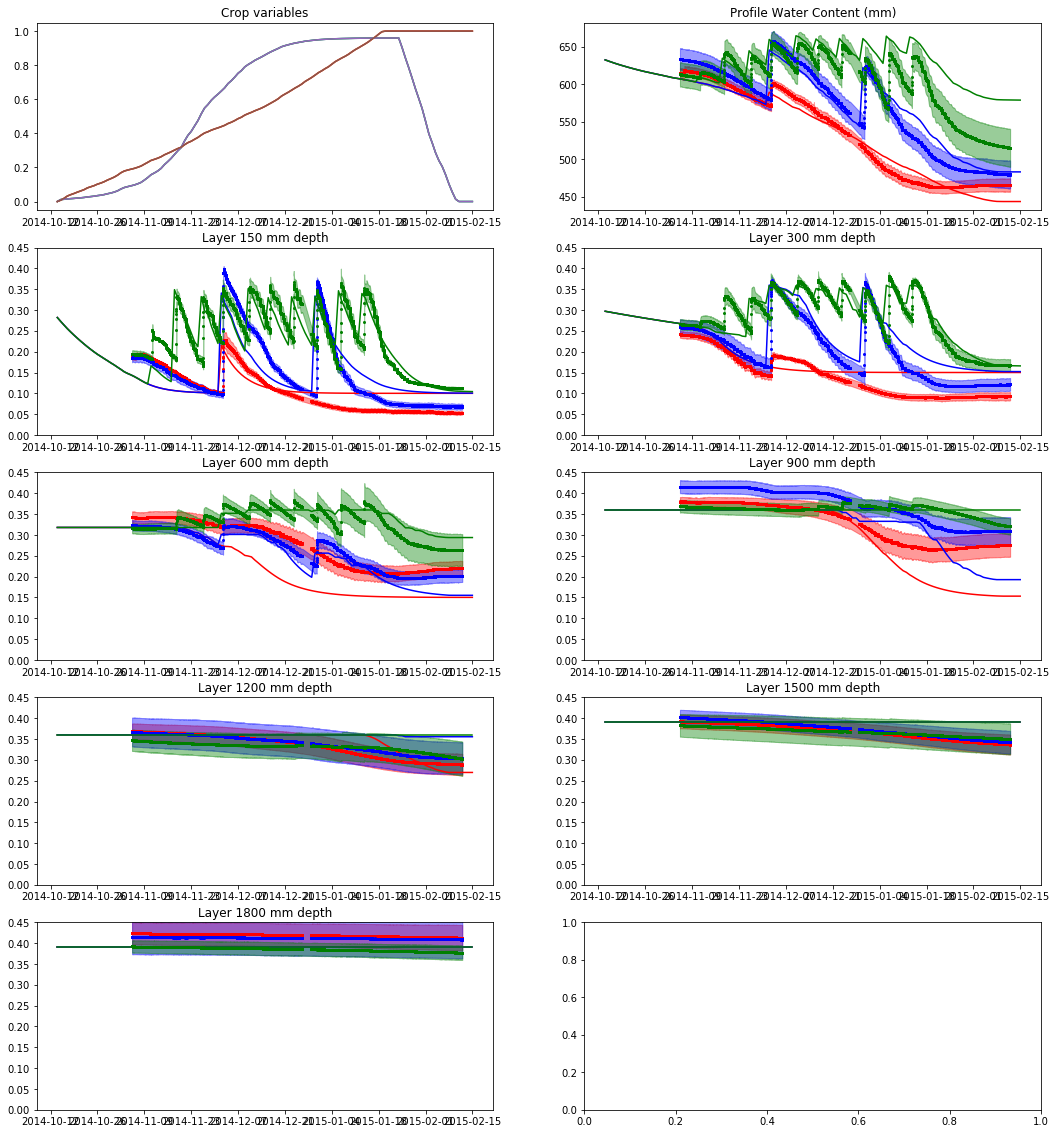

In [63]:
Treat = 1

for Irrig in Irrigations:    
    Cult = 'Dash'

    #Set simulation dates and crop
    StartDate = dt.datetime(2014,10,14)
    SowingDate = dt.datetime(2014,10,15)
    HarvestDate = dt.datetime(2015,2,15)
    CropSown = 'Barley (Spring)'
    RootRate = .7

    #Setup data structures
    DateIndex = MetData.ix[StartDate:HarvestDate].index
    Paddock = pd.DataFrame(index = DateIndex)
    Paddock.ix[:,'Tt'] = 0.0
    Paddock.ix[SowingDate:HarvestDate,'Tt'] = MetData.ix[SowingDate:HarvestDate,'mean'].cumsum()

    Irrigation = pd.read_pickle('Irrigation.pkl')
    Irrigation = Irrigation.ix[Paddock.index].fillna(0)

    #Set up crop variables
    SetCropVariables(CropSown,RootRate)

    #Calculate potential evapotranspiration calcualtions
    for date in Paddock.index:
        Paddock.ix[date,'EP'] = et.PenmanEO(MetData.ix[date,'radn'],MetData.ix[date,'mean'],MetData.ix[date,'wind'],MetData.ix[date,'vp'])
        Paddock.ix[date,'ES'] = Paddock.ix[date,'EP'] * (1-Paddock.ix[date,'cover']) 
        Paddock.ix[date,'ET'] = Paddock.ix[date,'EP'] * Paddock.ix[date,'cover']

    #initialise soil water content on first day
    for depth in Depths:
        key = 'SW' + str(depth)
        Paddock.ix[StartDate,key] = SoilWaterParams.ix[depth,'InitSW']

    #Calculate soil water balance on subsequent days
    for date in Paddock.index:
        if date > StartDate:
            doPrecipitation(date, Irrigation.ix[date,(Irrig,Cult)].mean())
            doEvaporation(date,Paddock.ix[date,'ES'])
            doTranspiration(date,Paddock.ix[date,'ET'])
    if Treat == 1:
        fig, axs = plt.subplots(5,2,figsize=(18,20))
    GraphWatBal(Irrig,Cult,fig,Treat)
    Treat += 1